In [1]:
import xarray as xr
import dask
import numpy as np
from datetime import datetime, timedelta
from cartopy.feature.nightshade import Nightshade
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os, glob, sys, gc
from tqdm.auto import tqdm
import pandas as pd

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
import glob
import os
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import xarray as xr

import importlib

import warnings

In [3]:
import utility_programs.filters as filters
from utility_programs.plotting_routines import panel_plot
from utility_programs.read_routines.GITM import auto_read as auto_read_gitm
from utility_programs.read_routines.GITM import gitm_times_from_filelist
from utility_programs.read_routines.SAMI import auto_read as auto_read_sami
from utility_programs import plotting_routines
from utility_programs.utils import ut_to_lt
from utility_programs.utils import add_lt_to_dataset

/glade/u/home/abukowski/Documents/CEDAR2023/utility_programs/plotting_routines.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [4]:
data = '/glade/u/home/abukowski/scratch/postprocessed/'

In [5]:
gitms = {}
samis = {}

for full_path in np.sort(glob.glob(os.path.join(data,'*.nc'))):

    fname = full_path[full_path.rfind('/')+1:]
    datas = fname[:-3].split('_')
    month = datas[0]

    if 'bz' in datas[1]:
        if 'SAMI' in datas:
            model = datas[-2] + '-'+datas[-1]
        else:
            model = datas[-1]
        month = datas[0]
        runname = datas[1][5:]
        onset = datas[2]
        duration = datas[3]

    elif 'thm' not in datas:
        if 'SAMI' in datas:
            model = datas[-2] + '-'+datas[-1]
        else:
            model = datas[-1]
        month = datas[0]
        runname = datas[1]
        onset = datas[2]
        duration = datas[3]
        
    else:
        continue

    if model == 'GITM':
        gitms['-'.join([month, onset, duration, runname])] = xr.open_mfdataset(full_path, engine='h5netcdf')

    elif model == 'SAMI-REGRID':
        samis['-'.join([month, onset, duration, runname])] = xr.open_mfdataset(full_path, engine='h5netcdf')


In [6]:
# Preprocess


## Time slicing
t_starts = {'ut6':'03:00:00', 'ut12':'09:00:00', 'ut18':'15:00:00'}

for k in gitms.keys():
    key = k.split('-')[1]
    t_start = gitms[k].time.values[0] + pd.Timedelta('1 day' + t_starts[key])
    t_end = t_start + pd.Timedelta('10 hours')
    
    gitms[k] = gitms[k].sel(time = slice(t_start, t_end))
    
for k in samis.keys():
    key = k.split('-')[1]
    t_start = samis[k].time.values[0] + pd.Timedelta('1 day' + t_starts[key])
    t_end = t_start + pd.Timedelta('8 hours')
    samis[k] = samis[k].sel(time = slice(t_start, t_end))    


In [47]:
def format_colname_for_title(runname):
    
    names = runname.split('-')
    outname = ' '.join([i[0].upper()+i[1:] for i in runname.split('-')])
    
    if 'Bz' in outname:
        outname = '$\mathrm{'+outname.replace('Bz', 'B_z=-') + '}$'
        if 'By' in outname:
            outname = outname.replace(' By', ', B_y=')
            
        outname = outname.replace(' ', '\ ')
            
    # outname = outname.replace('Storm ', 'Storm-')
    
    outname = outname.replace('neg', 'Negative')
    outname = outname.replace('pos', 'Positive')
    outname = outname.replace('Ut', 'UT')    
    return outname

# Bz Comparisons:

In [7]:
bzkeys = np.sort([k for k in gitms.keys() if 'bz' in k])

In [24]:
print(gitms['nov-ut12-storm-on-bz15-byneg'].data_vars), print(samis['nov-ut12-storm-on-bz15-byneg'].data_vars)

Data variables:
    LocalTime                        (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    SolarZenithAngle                 (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    VerticalTEC                      (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    AltIntJouleHeating_W_m2          (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    AltIntHeatingTransfer_W_m2       (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    AltIntEuvHeating_W_m2            (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    AltIntPhotoElectronHeating_W_m2  (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    AltIntChamicalHeating_W_m2       (time, lon, lat) float64 dask.array<chunksize=(120, 90, 180), meta=np.ndarray>
    AltIntRadCooling_W_m2            (time, lon, lat) fl

(None, None)

In [9]:
gitms['nov-ut12-storm-on-bz15-byneg'].O_2D_plus.max().compute(), gitms['nov-ut12-storm-on-bz15-byneg'].O_2P_plus.max().compute()

(<xarray.DataArray 'O_2D_plus' ()>
 array(7.81505097e+09),
 <xarray.DataArray 'O_2P_plus' ()>
 array(2.87046515e+08))

In [10]:
gcols = ['Vn_north','NO_plus','He_plus']
scols = ['edens','o+dens','he+dens','o2+dens']

plotcols = gcols + scols


In [11]:
print(plotcols)

['Vn_north', 'NO_plus', 'He_plus', 'edens', 'o+dens', 'he+dens', 'o2+dens']


In [12]:

# for run in bzkeys:
    
#     for col in plotcols:
        
#         if col in gitms[run].data_vars:
#             ds = gitms[run]
#             model='GITM'
#         elif col in samis[run].data_vars:
#             ds = samis[run]
#             model='SAMI3'
#         else:
#             raise ValueError(col, ' Not found')
        
#         filters.filter_xarray_DA_diff(ds[col].sel(lon=300,
#                                                   method='nearest'),
#                                      percent=True).sel(time='2011-11-21 14:00',
#                                                        method='nearest').plot(
#             x='lat',robust=True,cbar_kwargs={'label':'%s Percent over background'%col})
#         plt.title('Altitude Distrobution of %s From %s\n 2 Hours after Storm Onset\n From Run %s'
#                   %(col.replace('+', 'plus'), model, run))
#         plt.savefig('good-plots/rotB_alt-dist/%s-%s'%(run, col.replace('+', 'plus')))
#         plt.close()
                    
#_+++++++++++++++++++####
        # break
    # break
    
#     fig = plotting_routines.loop_panels(
#         ds[col],
#         ncols=1,
#         lon_labels=True,
#         mask_dials=0.002,
#         vmax=0.05,
#         cmap='rainbow',
#         start_time=pd.Timestamp('2011-11-21 12:30'),)

#     fig.suptitle('After Storm Onset From Run\n%s'%col[col.find('bz'):], fontsize='x-large')
#     fig.tight_layout()
#     fig.show()
#     # fig.savefig('good-plots/jh-rotb/after-%s'%col[col.find('bz'):], bbox_inches='tight');
    
#     break

In [13]:
for run in gitms.keys():
    
    if 'hr' in run and run.replace('1hr', 'on') in gitms.keys():
        print(run)

may-ut12-storm-1hr-full
may-ut6-storm-1hr-full
may-ut12-storm-1hr-half


In [14]:
for run in gitms.keys():
    
    if 'hr' in run and run.replace('1hr', 'on') in gitms.keys():
        print(run)

may-ut12-storm-1hr-full
may-ut6-storm-1hr-full
may-ut12-storm-1hr-half


In [15]:
utkeys = [['may-ut12-storm-on-full', 'may-ut18-storm-on-full', 'may-ut6-storm-on-full'],
         ['nov-ut12-storm-on-full', 'nov-ut18-storm-on-full', 'nov-ut6-storm-on-full']]

In [16]:
for ks in utkeys:
    for k in ks:
        print('%s \t storm on %s \t storm 1hr %s' %(k, k in gitms.keys(), k.replace('on','1hr') in gitms.keys()))

may-ut12-storm-on-full 	 storm on True 	 storm 1hr True
may-ut18-storm-on-full 	 storm on True 	 storm 1hr False
may-ut6-storm-on-full 	 storm on True 	 storm 1hr True
nov-ut12-storm-on-full 	 storm on True 	 storm 1hr False
nov-ut18-storm-on-full 	 storm on True 	 storm 1hr False
nov-ut6-storm-on-full 	 storm on True 	 storm 1hr False


In [17]:
glob.glob('/glade/u/home/abukowski/scratch/postprocessed/*1hr*')

['/glade/u/home/abukowski/scratch/postprocessed/may_full_ut6_storm-1hr_GITM.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/may_full_ut12_storm-1hr_GITM.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/may_half_ut12_storm-1hr_GITM.nc']

In [18]:
l= [i for i in glob.glob('/glade/u/home/abukowski/scratch/postprocessed/*ut*') if 'ut12' not in i]

In [19]:
l

['/glade/u/home/abukowski/scratch/postprocessed/may_full_ut18_storm-on_SAMI_REGRID.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/may_full_ut6_storm-1hr_GITM.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/may_full_ut6_storm-on_SAMI_REGRID.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/nov_full_ut18_storm-on_SAMI_REGRID.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/nov_full_ut6_storm-on_GITM.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/nov_full_ut18_storm-on_GITM.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/may_full_ut18_storm-on_GITM.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/nov_full_ut6_storm-on_SAMI_REGRID.nc',
 '/glade/u/home/abukowski/scratch/postprocessed/may_full_ut6_storm-on_GITM.nc']

In [20]:
from  utility_programs import utils 

In [21]:
lts_to_keo = [6,12,18,23.9]

gcols = ['Vn_north', 'Vn_east', 'NO_plus','He_plus', 'Temperature', 'iTemperature','eTemperature']
alts=[150,400, 650]

In [95]:
from matplotlib.dates import DateFormatter, AutoDateLocator, AutoDateFormatter

In [98]:
xtick_locator = AutoDateLocator(maxticks=5)
xtick_formatter = AutoDateFormatter(xtick_locator)

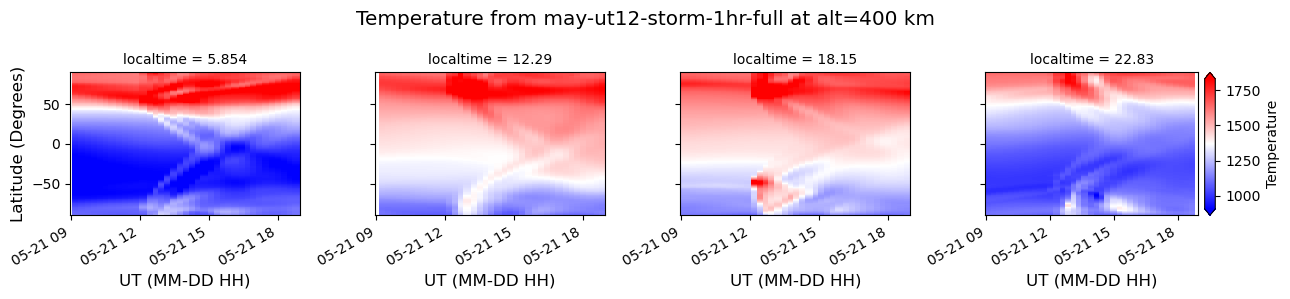

In [104]:
fig = utils.add_lt_to_dataset(#filters.filter_xarray_DA_diff(
                                gitms[run2][col].sel(alt=alt_now, method='nearest')
                                              ,localtimes = 40).sel(localtime=lts_to_keo,
                                                                    method='nearest').plot(col='localtime', 
                                                                                           col_wrap = 4,
                                                                                           x='time', robust=True,
                                                                                           cmap='bwr', add_colorbar=False,
                                                                                          sharey=True)

fig.set_xlabels('UT (MM-DD HH)', fontsize='large')
fig.set_ylabels("Latitude (Degrees)", fontsize='large')
# fig.fig.set_size_inches(fig.fig.get_size_inches()[0]-4, fig.fig.get_size_inches()[1])
# date_form = DateFormatter("%H:%M")

for ax in fig.axs.flatten():
    ax.xaxis.set_major_locator(xtick_locator)
    # ax.set_xticks( set_ticks(max_xticks=6)
    ax.xaxis.set_major_formatter(xtick_formatter)


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.add_colorbar(cax=cax, )
fig.fig.suptitle('%s from %s at alt=%i km' %(col, run2, alt_now), fontsize='x-large')
fig.fig.set_layout_engine('tight', )
plt.show() #savefig('good-plots/gitm-keos-1hrvson/gitm-keos2-'+run2+'-'+str(alt_now)+'-'+str(alt_now), bbox_inches='tight')
# pbar.update()

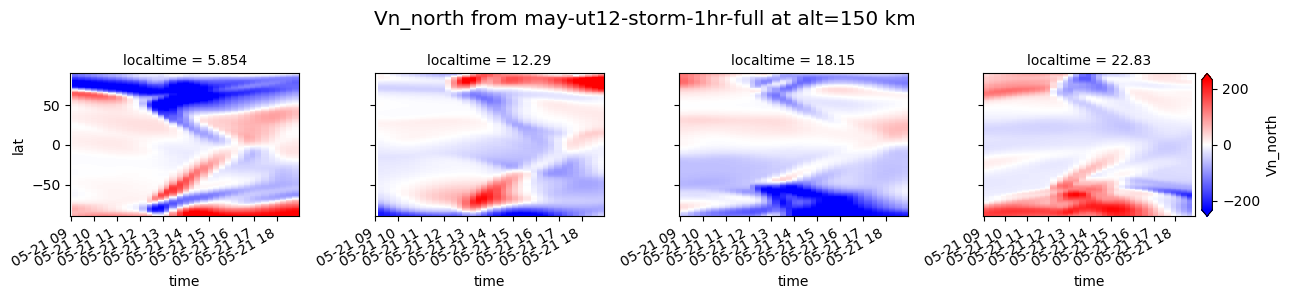

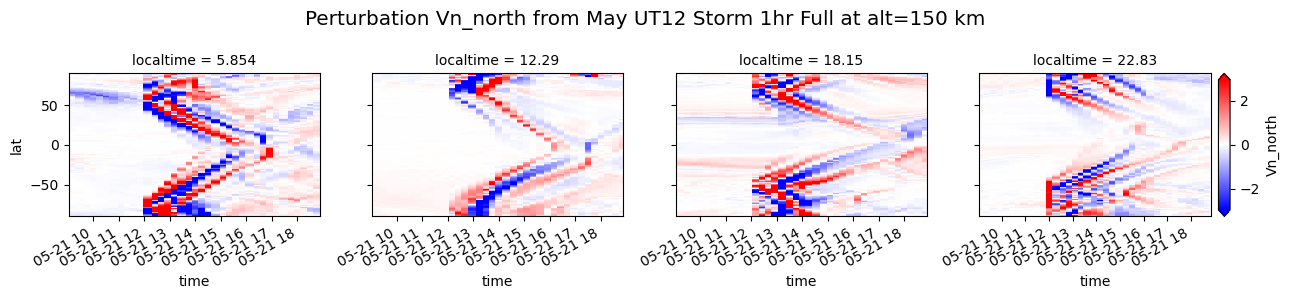

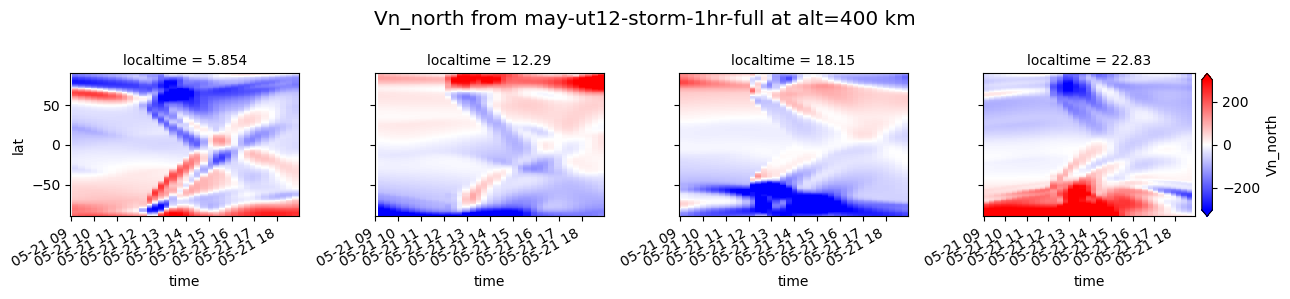

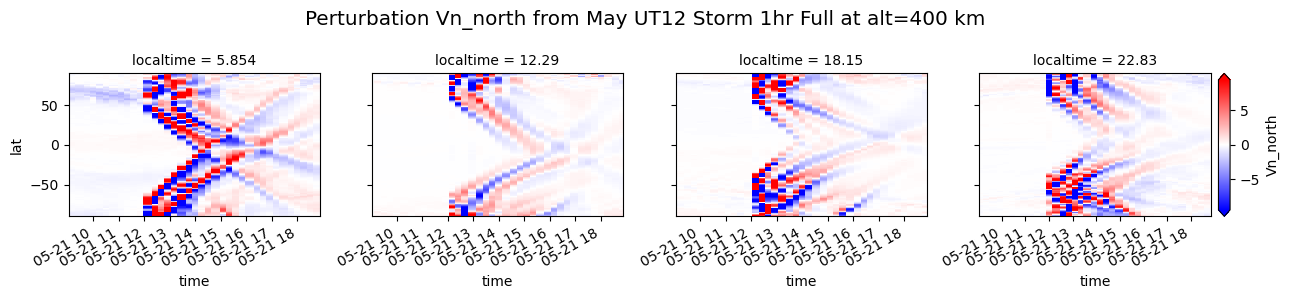

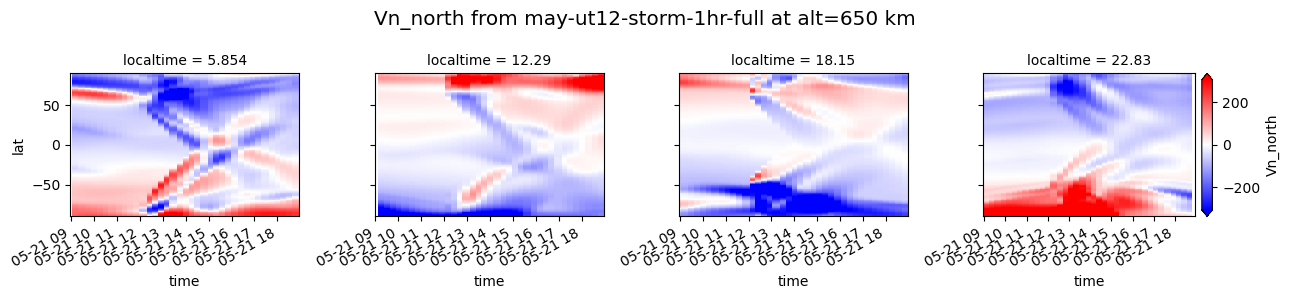

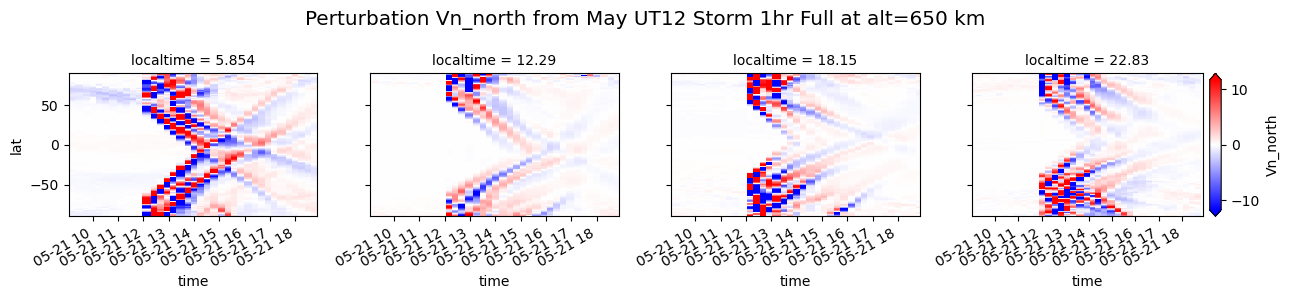

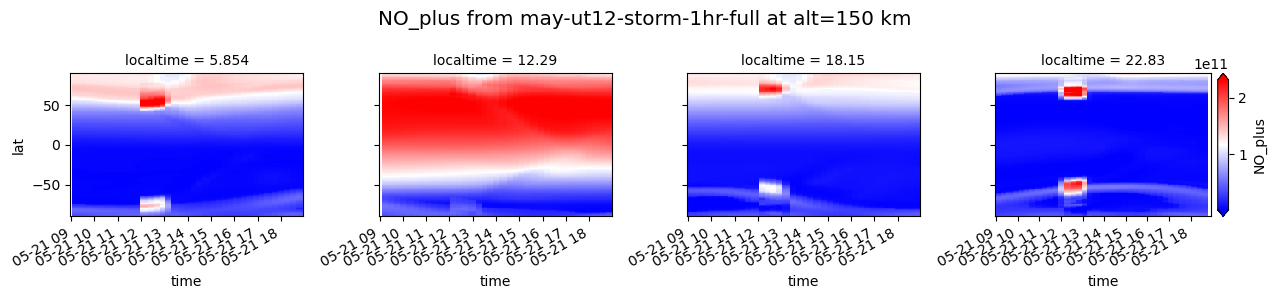

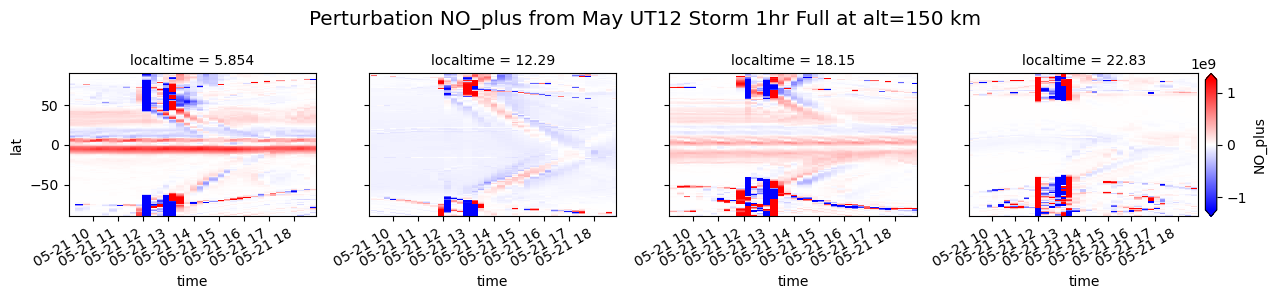

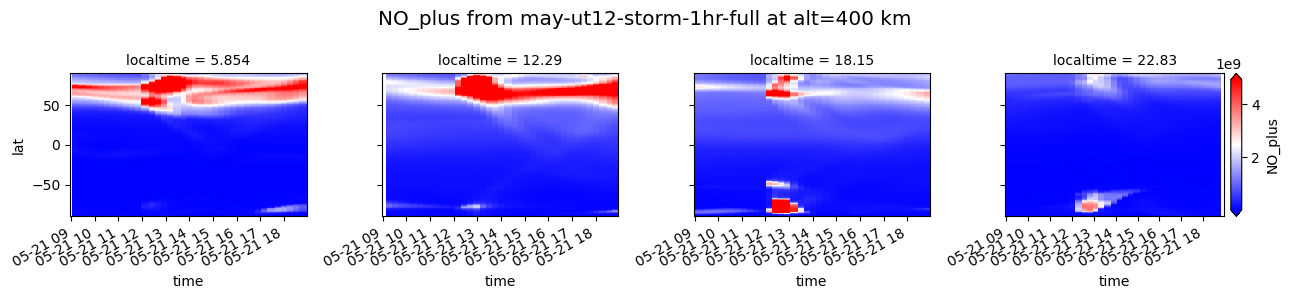

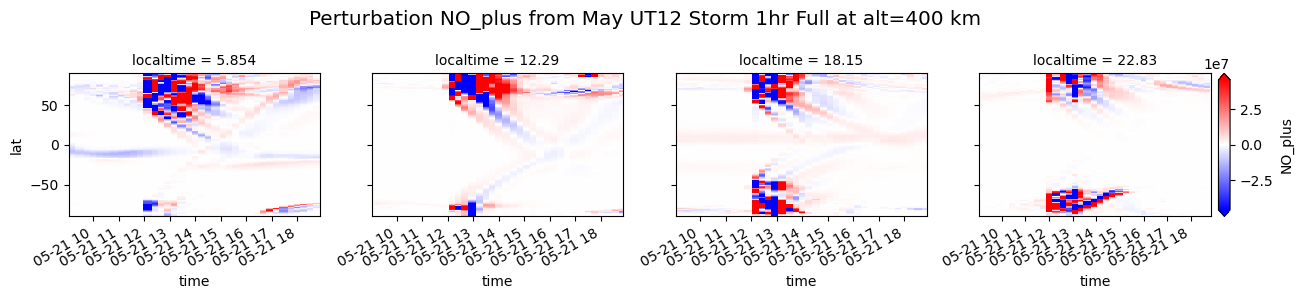

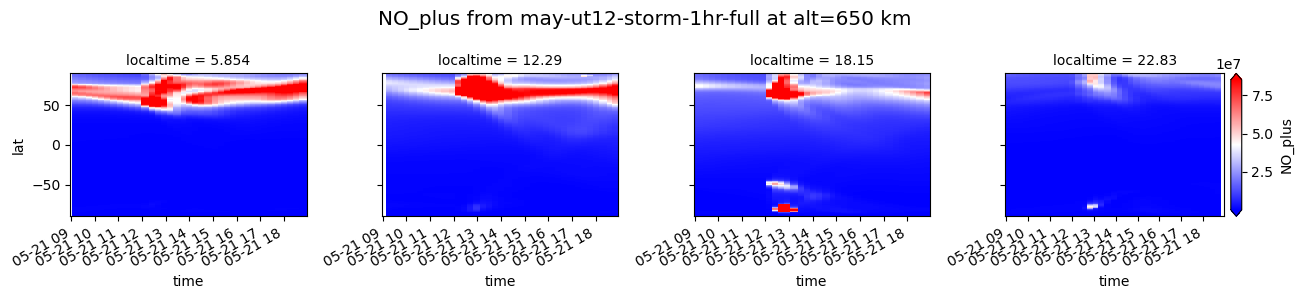

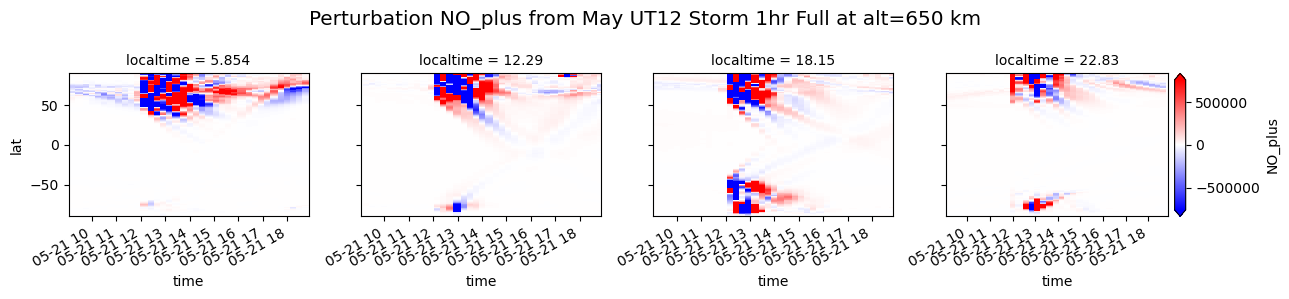

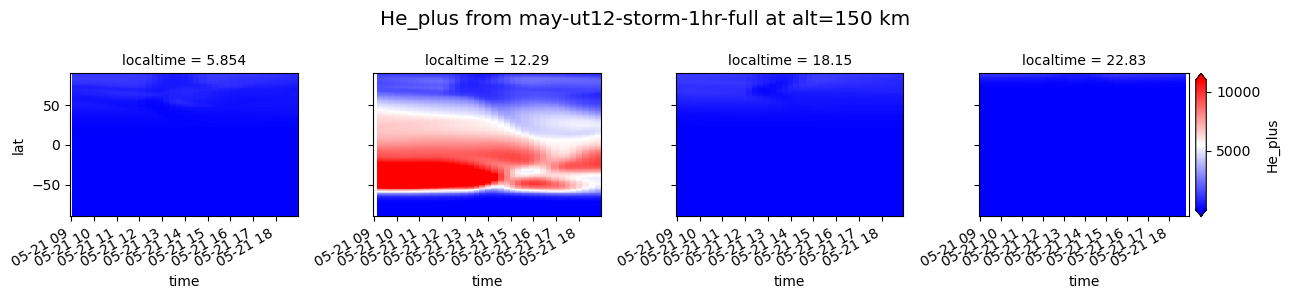

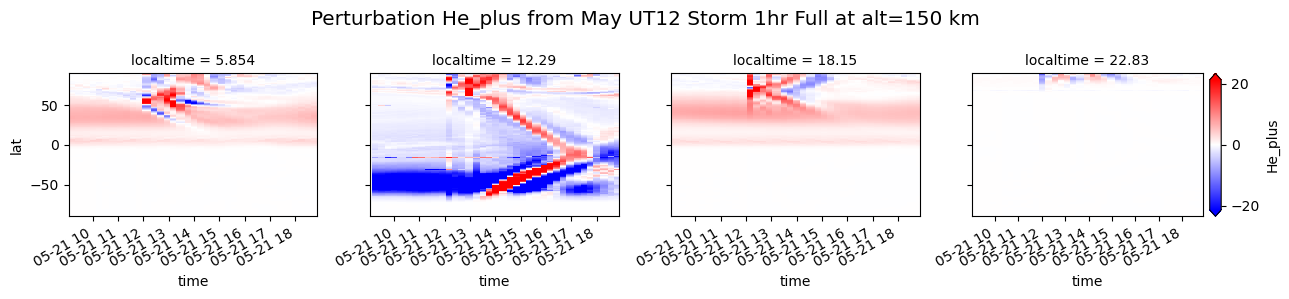

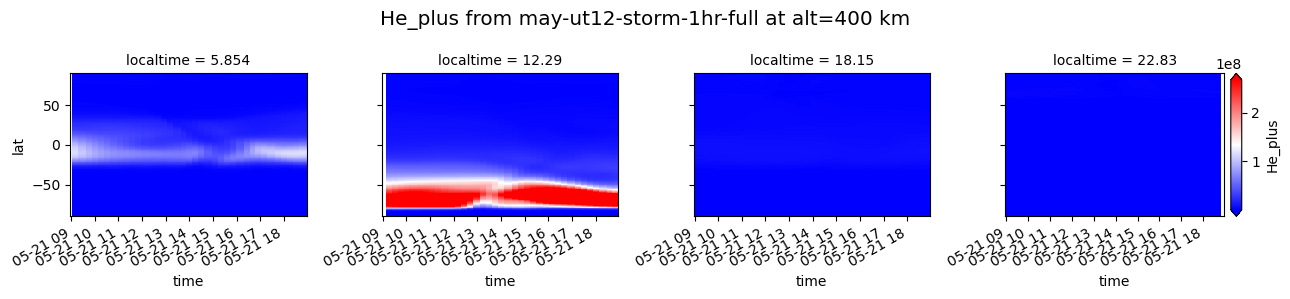

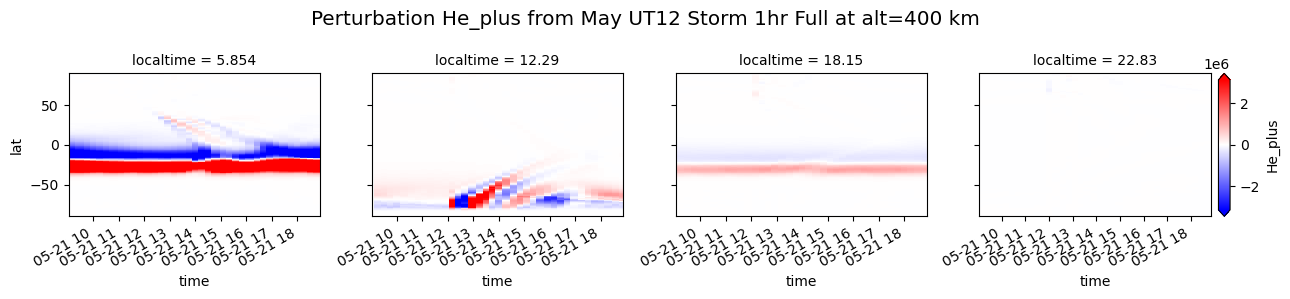

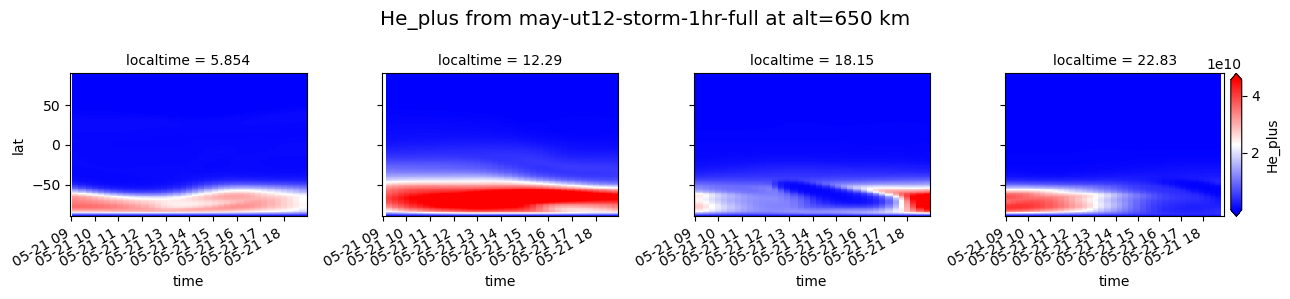

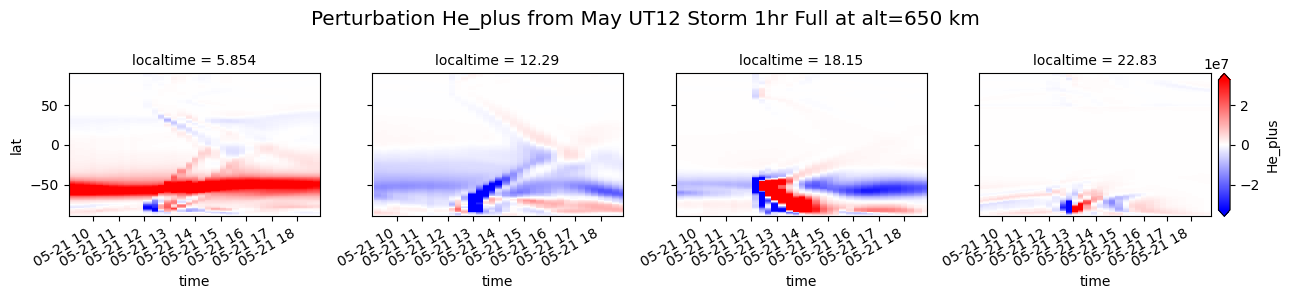

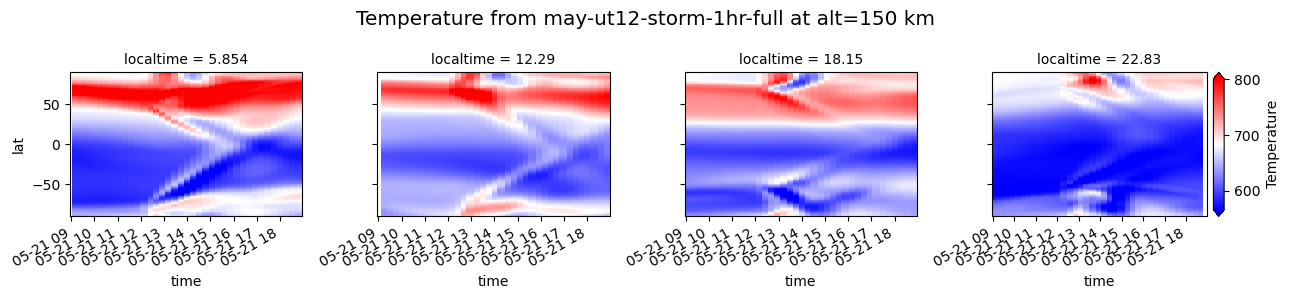

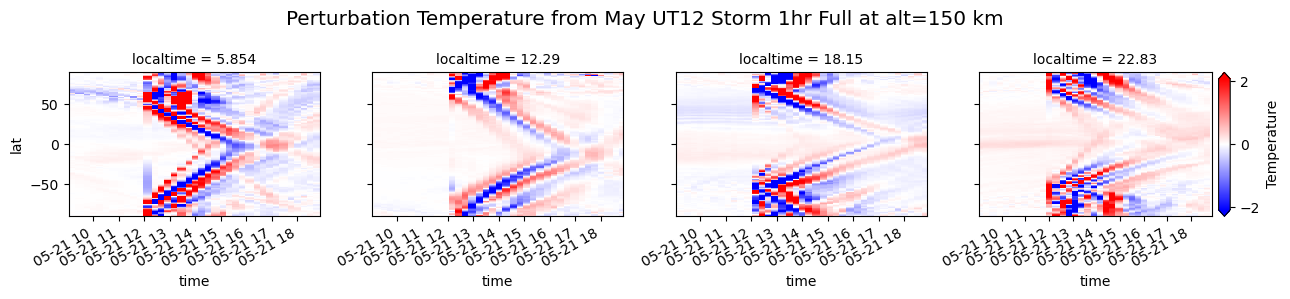

KeyboardInterrupt: 

In [49]:

for run2 in gitms.keys():
    if 'hr' in run2 or run2.replace('on', '1hr') in run2:
        for col in gcols:
            for alt_now in alts:
                fig = utils.add_lt_to_dataset(#filters.filter_xarray_DA_diff(
                                gitms[run2][col].sel(alt=alt_now, method='nearest')
                                              ,localtimes = 40).sel(localtime=lts_to_keo,
                                                                    method='nearest').plot(col='localtime',
                                                                                           col_wrap = 4,
                                                                                           x='time', robust=True,
                                                                                           cmap='bwr', add_colorbar=False)

                divider = make_axes_locatable(plt.gca())
                cax = divider.append_axes("right", "5%", pad="3%")
                fig.add_colorbar(cax=cax)
                fig.fig.suptitle('%s from %s at alt=%i km' %(col, run2, alt_now), fontsize='x-large')
                fig.fig.set_layout_engine('tight', )
                plt.show() #savefig('good-plots/gitm-keos-1hrvson/gitm-keos2-'+run2+'-'+str(alt_now)+'-'+str(alt_now), bbox_inches='tight')
                # pbar.update()
                
                fig = utils.add_lt_to_dataset(filters.filter_xarray_DA_diff(
                                gitms[run2][col].sel(alt=alt_now, method='nearest'))
                                              ,localtimes = 40).sel(localtime=lts_to_keo,
                                                                    method='nearest').plot(col='localtime',
                                                                                           col_wrap = 4,
                                                                                           x='time', robust=True,
                                                                                           cmap='bwr', add_colorbar=False)

                divider = make_axes_locatable(plt.gca())
                cax = divider.append_axes("right", "5%", pad="3%")
                fig.add_colorbar(cax=cax)
                fig.fig.suptitle('Perturbation %s from %s at alt=%i km' %(col, format_colname_for_title(run2), alt_now), fontsize='x-large')
                fig.fig.set_layout_engine('tight', )
                plt.show() #savefig('good-plots/gitm-keos-1hrvson/gitm-keos2-'+run2+'-'+str(alt_now)+'-'+str(alt_now), bbox_inches='tight')
                # pbar.update()
                
                
print('done')

In [32]:
run2

'nov-ut12-storm-on-bz8-bypos'

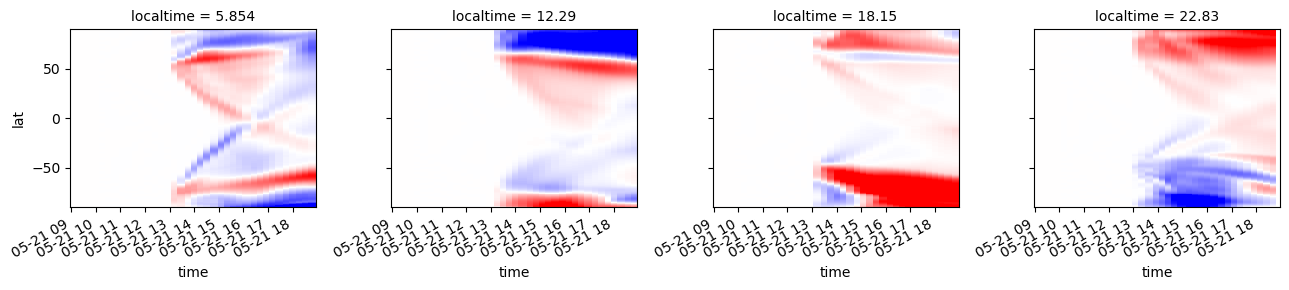

In [33]:
fig = utils.add_lt_to_dataset(
                        gitms[hrkey][col].sel(alt=alt_now, method='nearest') - gitms[hrkey.replace('1hr', 'on')][col].sel(
                            alt=alt_now, method='nearest').reindex_like(gitms[hrkey][col], method='nearest'),
                        localtimes=40).sel(localtime=lts_to_keo,
                                           method='nearest').plot(col='localtime',
                                                                  col_wrap=4,
                                                                  x='time', robust=True,
                                                                  cmap='bwr', add_colorbar=False)


In [34]:
hrkey

'may-ut12-storm-1hr-full'

In [39]:
'_'.join([i[0].upper()+i[1:] for i in hrkey.split('-')])

'May_Ut12_Storm_1hr_Full'

'nov-ut12-storm-on-bz8-bypos'

In [113]:
s = format_colname_for_title(hrkey.replace('1hr', 'on')).split(' ')
' '.join([s[0], s[3]])

'May On'

In [115]:
gcols = ['Rho', 'Temperature']
alts

[150, 400, 650]

In [119]:
from matplotlib.dates import DateFormatter, AutoDateLocator, AutoDateFormatter

In [120]:
xtick_locator = AutoDateLocator(maxticks=6)
xtick_formatter = AutoDateFormatter(xtick_locator)

In [122]:
[i for i in gitms.keys() if 'hr' in i]

['may-ut12-storm-1hr-full',
 'may-ut6-storm-1hr-full',
 'may-ut12-storm-1hr-half']

In [ ]:
def duration_figs(ds,
                  

100%|██████████| 18/18 [12:17<00:00, 40.96s/it]


done


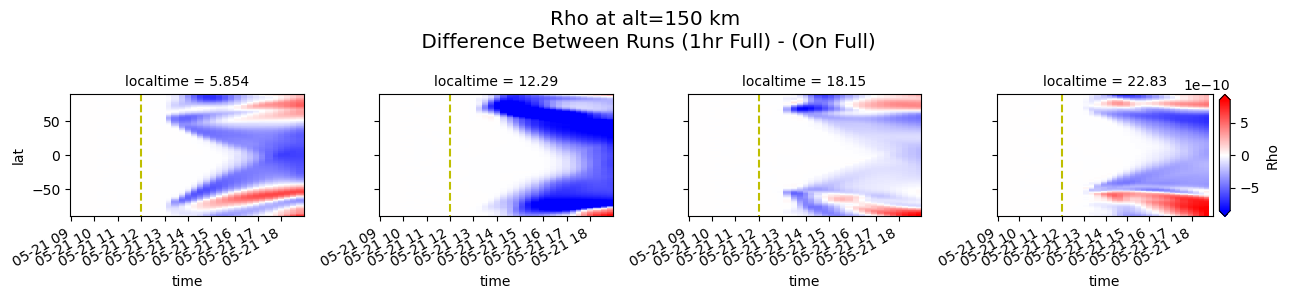

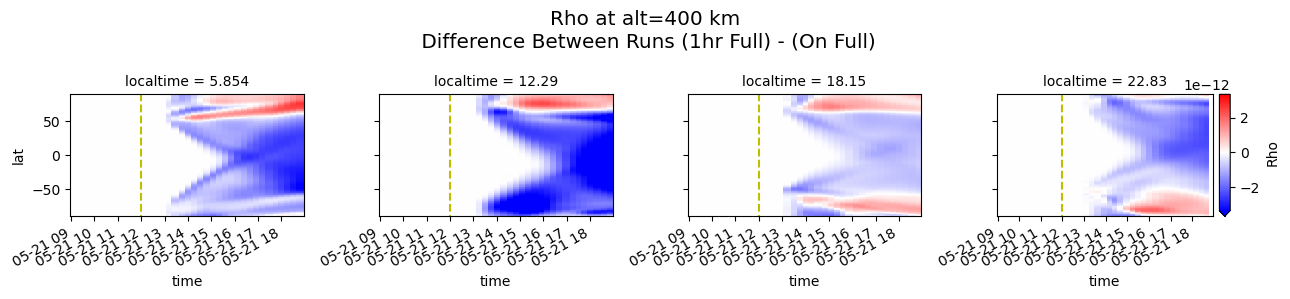

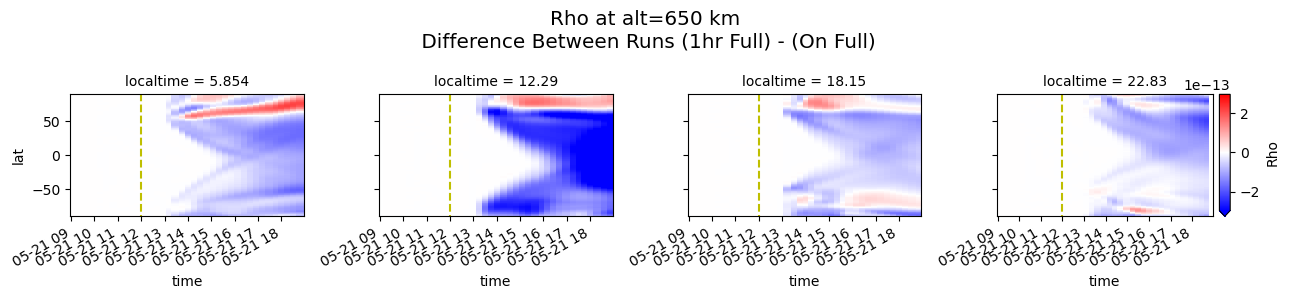

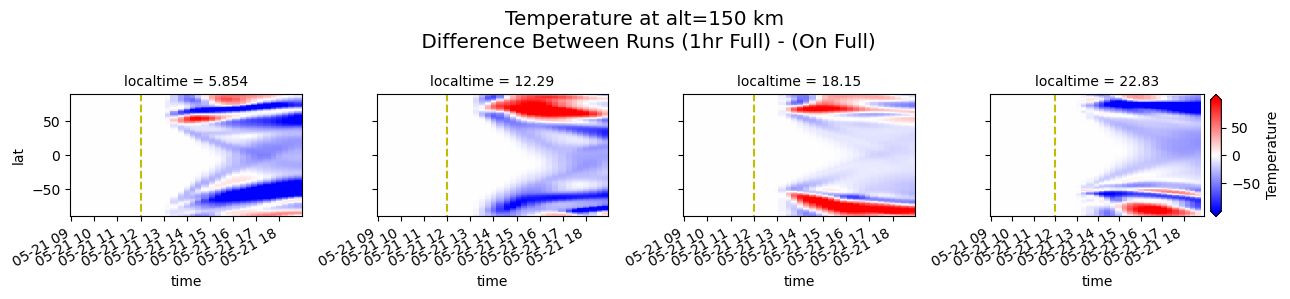

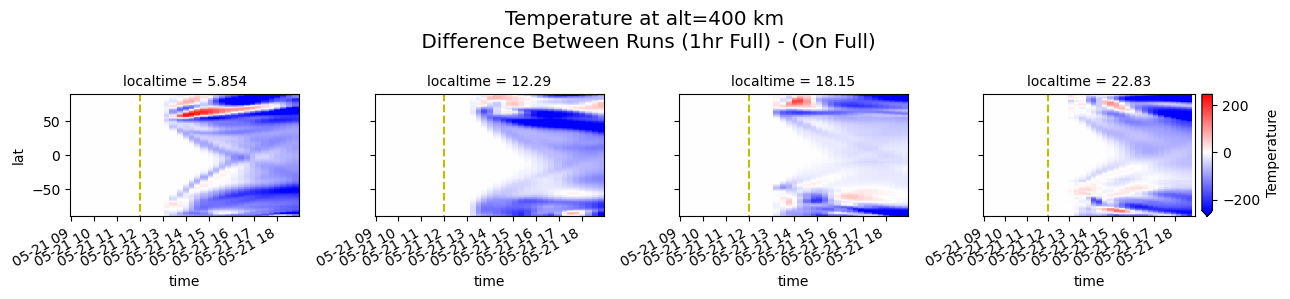

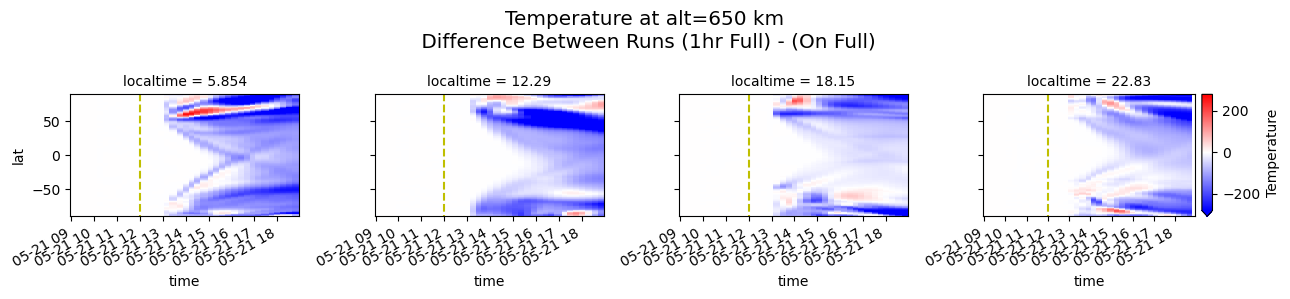

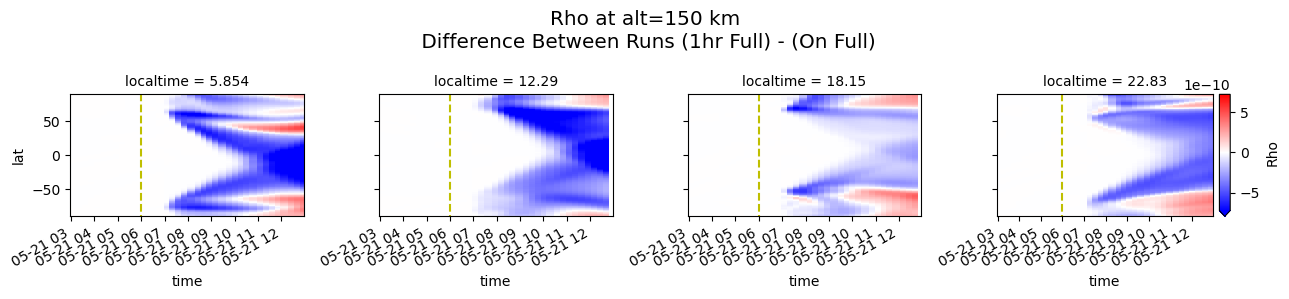

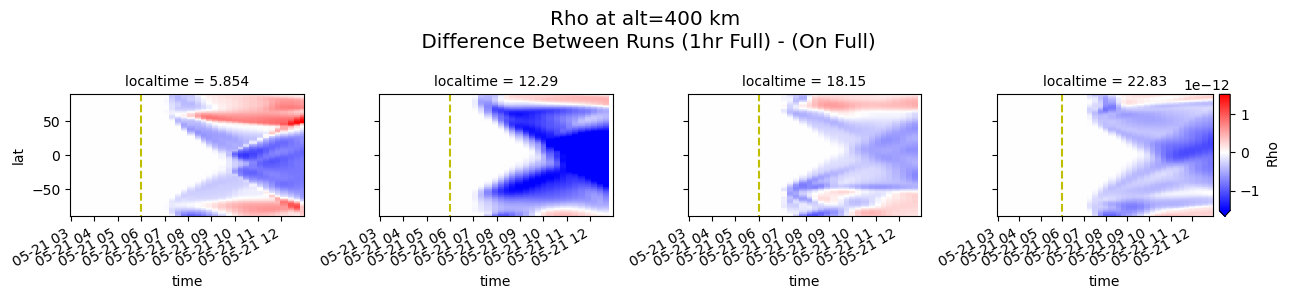

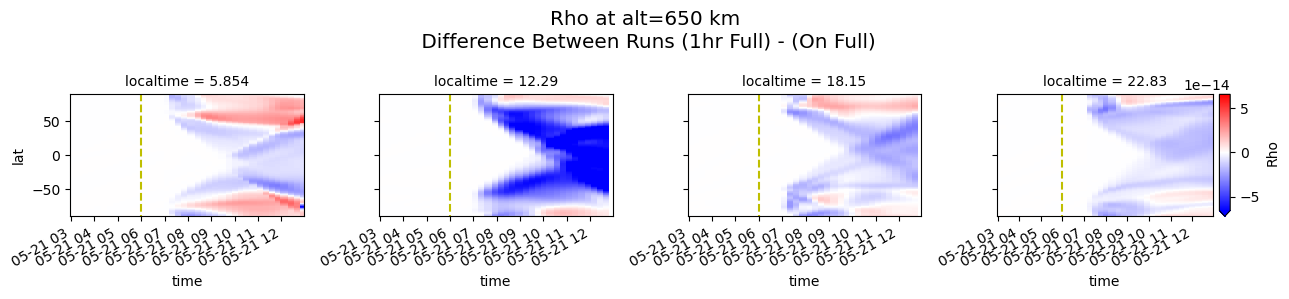

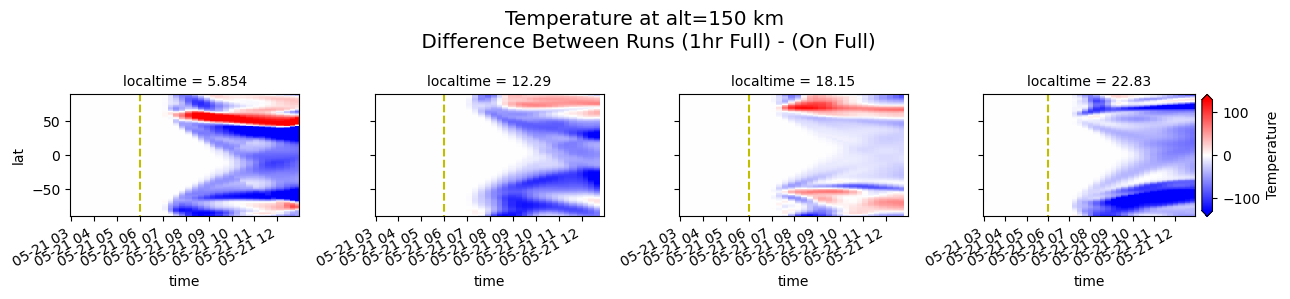

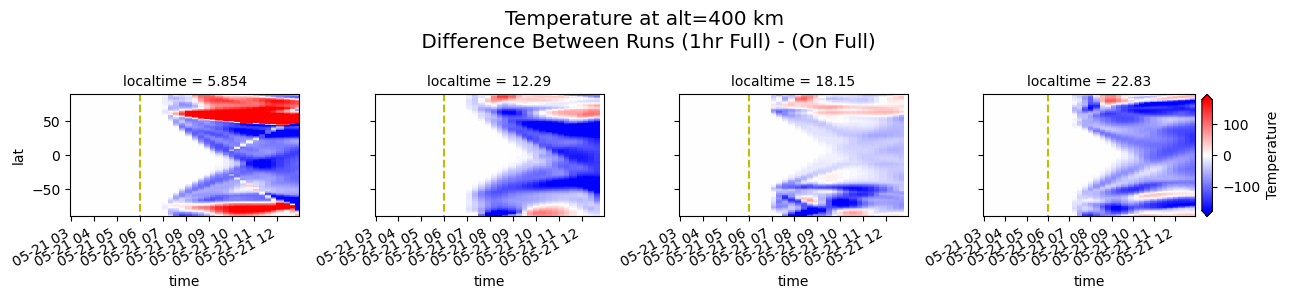

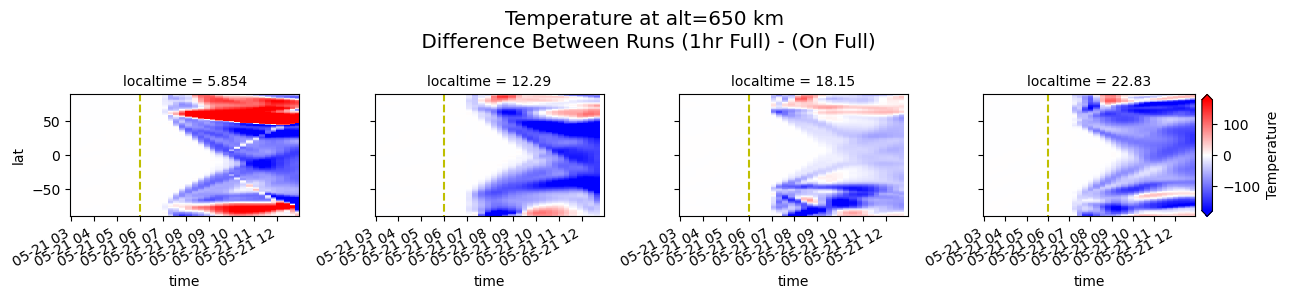

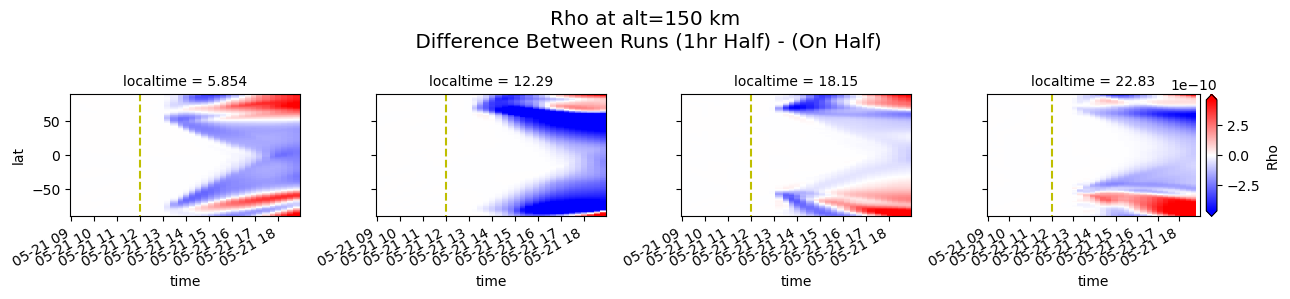

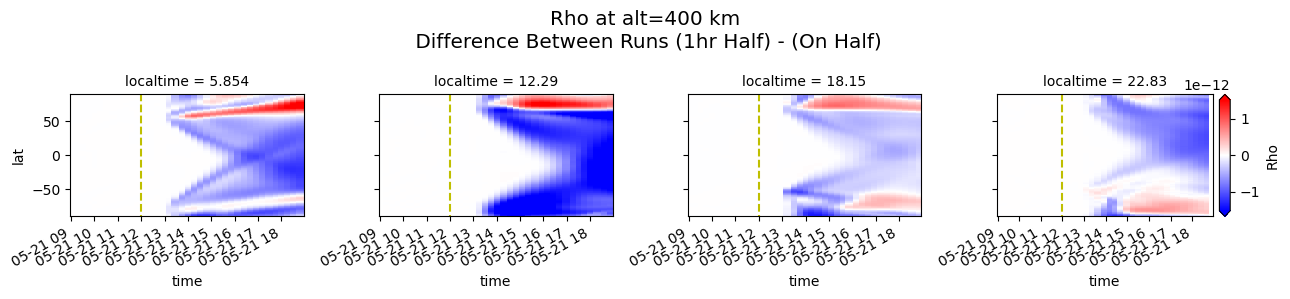

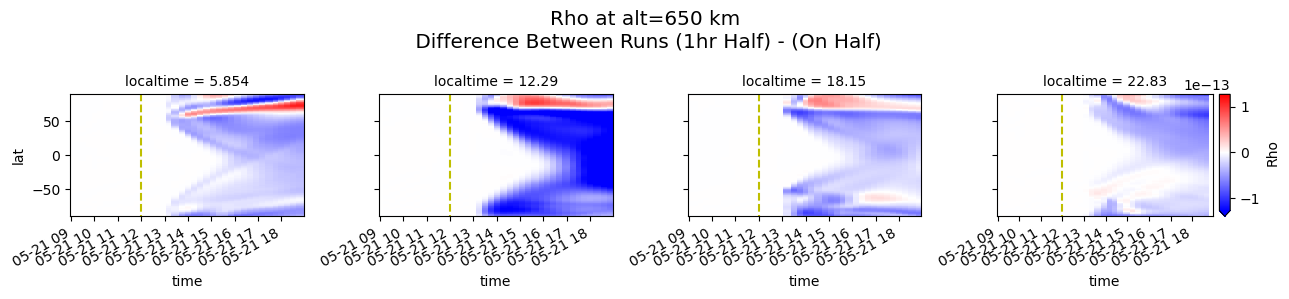

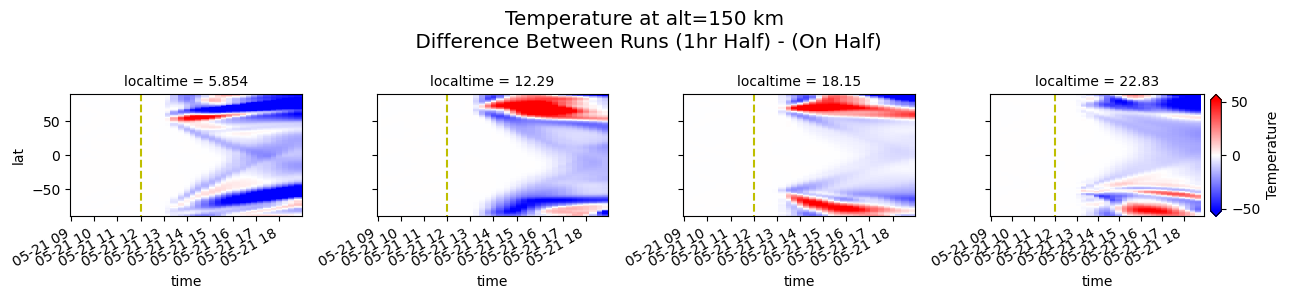

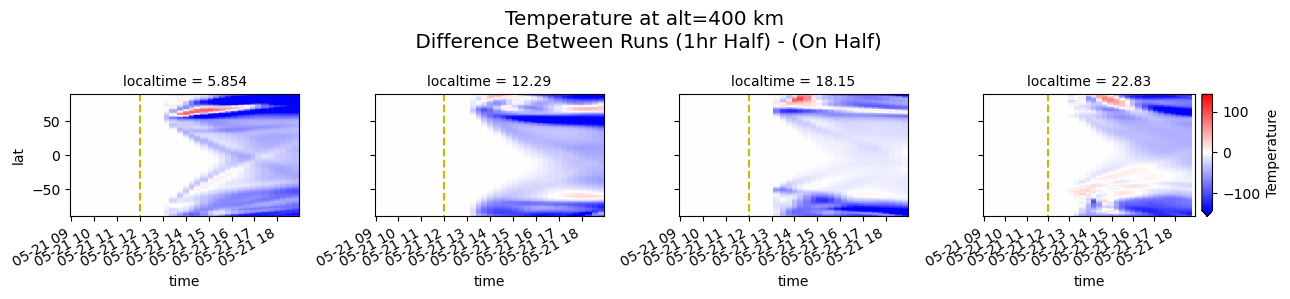

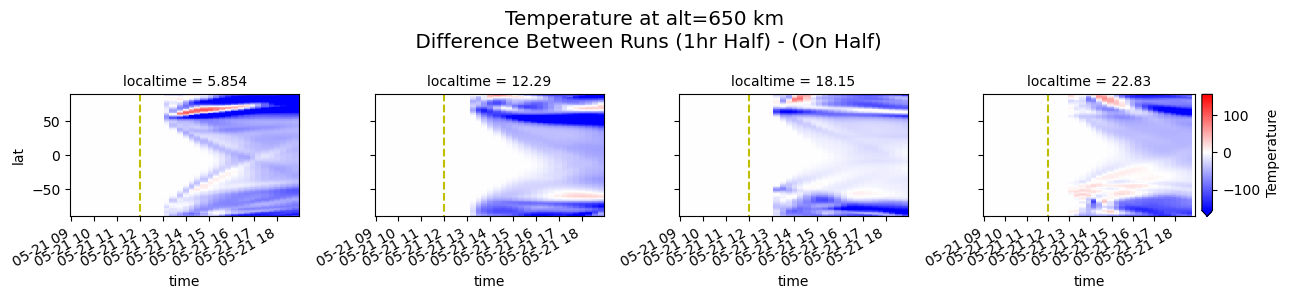

In [132]:
with tqdm(total=3*3*2) as pbar:
    for hrkey in gitms.keys():
        if 'hr' in hrkey:
            for col in gcols:
                for alt_now in alts:
                    fig = utils.add_lt_to_dataset(
                        gitms[hrkey][col].sel(alt=alt_now, method='nearest') - gitms[hrkey.replace('1hr', 'on')][col].sel(
                            alt=alt_now, method='nearest').reindex_like(gitms[hrkey][col], method='nearest'),
                        localtimes=40).sel(localtime=lts_to_keo,
                                           method='nearest').plot(col='localtime',
                                                                  col_wrap=4,
                                                                  x='time', robust=True,
                                                                  cmap='bwr',
                                                                  add_colorbar=False,
                                                                  sharey=True)

                    divider = make_axes_locatable(plt.gca())
                    cax = divider.append_axes("right", "5%", pad="3%")
                    fig.add_colorbar(cax=cax)
                    s1 = format_colname_for_title(hrkey).split(' ')
                    s1 = ' '.join([s1[3], s1[4]])
                    s2 = format_colname_for_title(hrkey.replace('1hr', 'on')).split(' ')
                    s2 = ' '.join([s2[3], s2[4]])
                    
                    fig.fig.suptitle('%s at alt=%i km\n Difference Between Runs (%s) - (%s)' %
                                     (col, alt_now, s1, s2), fontsize='x-large')


                    for ax in fig.axs.flatten():
                        ax.axvline(pd.Timedelta('3 hours') + gitms[hrkey].time.values[0],
                                   -90, 90, color='y',
                                  linestyle='--')
                    
                    
                    
                    fig.fig.set_layout_engine('tight', )
                    plt.savefig('FinalDraftPlots/1hrvson/yes_subtract/gitm-keos-'+hrkey+'-'+str(alt_now)+'-'+str(col), bbox_inches='tight')
                    pbar.update()
                    # raise

                
print('done')

In [130]:
pd.Timedelta('5 minutes') + (gitms[hrkey].time[0].values)

Timestamp('2011-05-21 09:05:00.031000')

In [107]:
print([i for i in gitms.keys() if 'hr' in i])

['may-ut12-storm-1hr-full', 'may-ut6-storm-1hr-full', 'may-ut12-storm-1hr-half']
